# Summary of the methodology and outcomes:

Here, we use only the engineered features (df_feat_eng) to predict the variants. We apply the same methodology as for the full dataset. The decision tree enables to discover that the number of pawns on the board is the most important feature, followed by the number of moves, captures and checks. Some key squares also play a important role.  

In terms of predictive power, the accuracy has decreased compared to the methodology using the full dataset, but so does also the training time of the best model: an SVM model. 

# Modelling

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df_feat_eng = pd.read_pickle('datasets/df_feat_eng')

In [3]:
df_feat_eng.head()

,variant,nb_moves,nb_K,nb_Q,nb_R,nb_B,nb_N,nb_P,nb_k,nb_q,...,nb_pawns_ext_center,nb_pawns_third_row_c_f,nb_pawns_b_g_col,nb_pieces_center,nb_pieces_ext_center,nb_pieces_third_row_c_f,nb_pieces_b_g_col,knight_squares,king_castle_squares,nb_checks
0,blitz,10,1,1,2,2,2,8,1,1,...,1,3,1,1,1,3,0,3,2,0
1,blitz,10,1,1,2,2,1,8,1,1,...,1,2,2,0,0,1,0,1,2,0
2,blitz,10,1,1,2,2,2,7,1,1,...,0,1,0,0,0,3,1,2,1,0
3,blitz,10,1,1,2,2,2,7,1,1,...,0,2,0,0,0,5,2,4,2,0
4,blitz,10,1,1,2,2,2,7,1,1,...,2,1,1,0,0,3,0,4,2,0


In [4]:
variants = ['antichess', 'atomic', 'blitz', 'chess960', 'crazyhouse', 'horde', 'kingOfTheHill', 'racingKings', 'threeCheck']

# Methodlogy

# Creating Train/Validation/Test set

In [5]:
X_tr, X_te, y_tr, y_te = train_test_split(
     df_feat_eng.drop('variant', axis=1), df_feat_eng['variant'], test_size=1/10, random_state=0, stratify =  df_feat_eng['variant'])

# cross validation strategy
kfold = KFold(
    n_splits=5, 
    random_state=0) 

In [6]:
print("Shape X_tr:" , X_tr.shape, 
      "\nShape X_te:", X_te.shape,      
      "\nShape y_tr:" , y_tr.shape, 
      "\nShape y_te:" , y_te.shape)

Shape X_tr: (8100, 29) 
Shape X_te: (900, 29) 
Shape y_tr: (8100,) 
Shape y_te: (900,)


In [7]:
y_tr.value_counts()

atomic           900
kingOfTheHill    900
crazyhouse       900
horde            900
antichess        900
chess960         900
racingKings      900
threeCheck       900
blitz            900
Name: variant, dtype: int64

In [8]:
y_te.value_counts()

threeCheck       100
atomic           100
chess960         100
horde            100
racingKings      100
kingOfTheHill    100
antichess        100
blitz            100
crazyhouse       100
Name: variant, dtype: int64

# Simple Decision Tree

In [9]:
# model 
model = DecisionTreeClassifier()

# grid search
grid = {
    'criterion': ['gini','entropy'], 
    'max_depth': [2,5,8,10,12,15,20,50,100,150]
}

# grid-search + CV
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [10]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
dt_tune_time = time.time() - start_time

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    6.0s finished


In [11]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(dt_tune_time, 1)))

,param_criterion,param_max_depth,mean_test_score,std_test_score
5,gini,15,0.687778,0.010983
4,gini,12,0.683580,0.006655
7,gini,20,0.677531,0.004662
6,gini,18,0.675802,0.006755
17,entropy,12,0.671605,0.008937
3,gini,10,0.670000,0.005502
18,entropy,15,0.669877,0.013126
8,gini,30,0.667778,0.011682
16,entropy,10,0.667037,0.012875
19,entropy,18,0.666667,0.015504


We can expect an accuracy close to 68.8% on the testing set with the following parameters: 
{'criterion': 'gini', 'max_depth': 15}. 
The tuning time is 6.1 sec.


In [12]:
dt = DecisionTreeClassifier(
    **grid_cv.best_params_, random_state=0)

In [13]:
start_time = time.time()
dt.fit(X_tr, y_tr)
dt_train_time = time.time() - start_time

In [14]:
dt_accuracy = dt.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(dt_accuracy*100))

Accuracy on Testing Set: accuracy: 70.8%.


In [15]:
dt_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
dt_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.92,0.02,0.01,0.00,0.00,0.0,0.02,0.0,0.00
atomic,0.03,0.81,0.01,0.03,0.02,0.0,0.00,0.0,0.05
blitz,0.01,0.02,0.51,0.11,0.16,0.0,0.22,0.0,0.13
chess960,0.01,0.08,0.11,0.72,0.14,0.0,0.10,0.0,0.12
crazyhouse,0.02,0.01,0.10,0.07,0.48,0.0,0.10,0.0,0.20
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.01,0.22,0.03,0.07,0.0,0.51,0.0,0.08
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.05,0.04,0.04,0.13,0.0,0.05,0.0,0.42


In [16]:
dt_metrics=pd.DataFrame(classification_report(dt.predict(X_te), y_te, output_dict=True)).T.round(3)
dt_metrics

,f1-score,precision,recall,support
antichess,0.934,0.920,0.948,97.0
atomic,0.831,0.810,0.853,95.0
blitz,0.472,0.510,0.440,116.0
chess960,0.632,0.720,0.562,128.0
crazyhouse,0.485,0.480,0.490,98.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.528,0.510,0.548,93.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.486,0.420,0.575,73.0
micro avg,0.708,0.708,0.708,900.0


Obviously, the accuracy is a bit below the accuracy of the decision tree when we used the full dataset. But the difference is not big and the computational time quite lower.

## Visualising the decision tree

In [17]:
tree_graph = export_graphviz(
    dt, 
    max_depth=4,
    feature_names = X_tr.columns,
    class_names = variants,
    filled=True, rounded=True, proportion=True
)

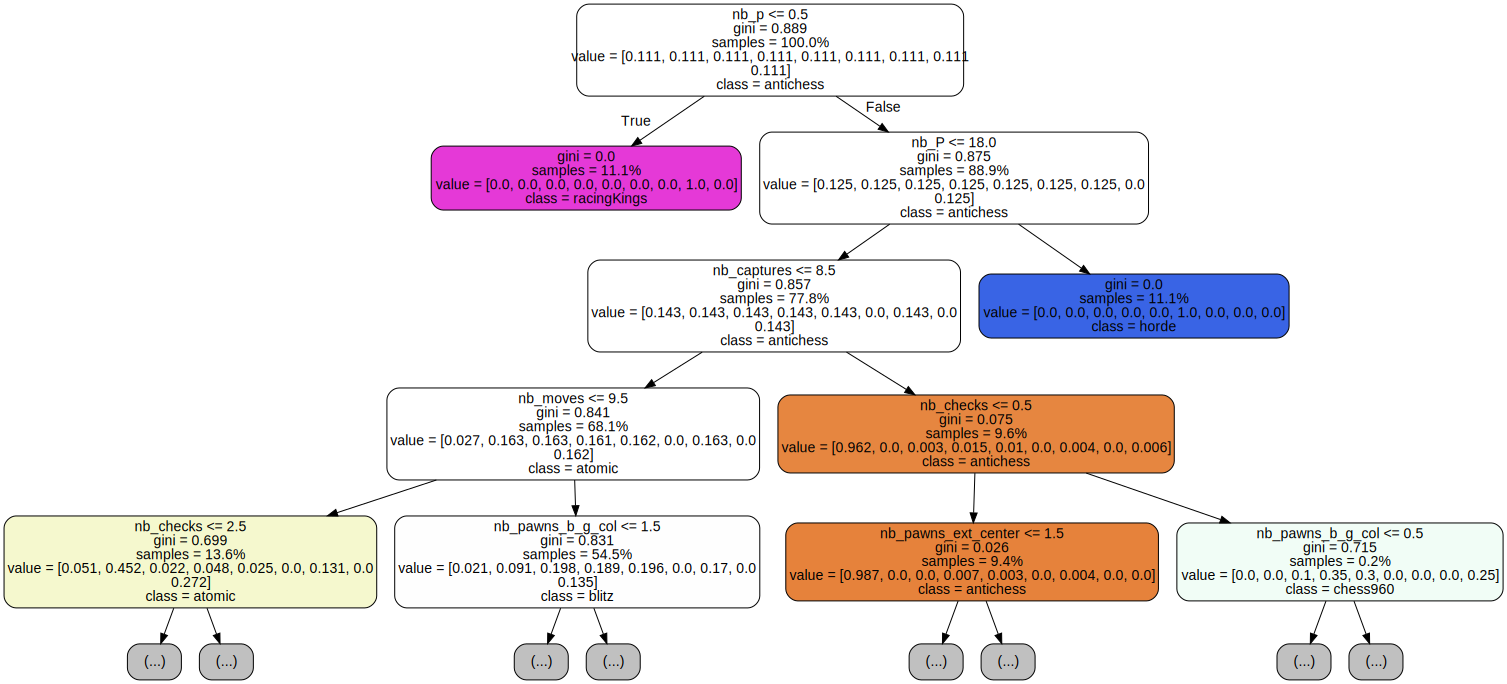

In [18]:
graphviz.Source(tree_graph, format="png") 

In [19]:
print(variants) # reminder to interpret the probabilities

['antichess', 'atomic', 'blitz', 'chess960', 'crazyhouse', 'horde', 'kingOfTheHill', 'racingKings', 'threeCheck']


The most important feature is again the number of pawns to segregate the two usual variants. Again, the number of captures, the number of moves and the number of checks play an important role. As these features were also present when using the full dataset, it seems that the job done in the engineering part was done quite well.  

# Logistic Regression

In [20]:
# Define our steps
model = LogisticRegression()

# grid 
grid = {
    'C': np.logspace(-3, 5, num=10),
}

# Grid search
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [21]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
logistic_tune_time = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.7s finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [22]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(logistic_tune_time, 1)))

,param_C,mean_test_score,std_test_score
8,12915.5,0.783086,0.002636
9,100000,0.783086,0.002636
7,1668.1,0.782099,0.002895
6,215.443,0.780988,0.003671
5,27.8256,0.773580,0.006455
4,3.59381,0.762222,0.006312
3,0.464159,0.739753,0.008045
2,0.0599484,0.724938,0.009111
1,0.00774264,0.704815,0.011365
0,0.001,0.672099,0.011297


We can expect an accuracy close to 78.3% on the testing set with the following parameters: 
{'C': 12915.496650148827}. 
The tuning time is 48.8 sec.


In [23]:
logistic = LogisticRegression(
    **grid_cv.best_params_, random_state=0)

In [24]:
start_time = time.time()
logistic.fit(X_tr, y_tr)
logistic_train_time = time.time() - start_time

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [25]:
logistic_accuracy = logistic.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(logistic_accuracy*100))

Accuracy on Testing Set: accuracy: 80.4%.


In [26]:
logistic_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
logistic_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.92,0.02,0.01,0.00,0.00,0.0,0.02,0.0,0.00
atomic,0.03,0.81,0.01,0.03,0.02,0.0,0.00,0.0,0.05
blitz,0.01,0.02,0.51,0.11,0.16,0.0,0.22,0.0,0.13
chess960,0.01,0.08,0.11,0.72,0.14,0.0,0.10,0.0,0.12
crazyhouse,0.02,0.01,0.10,0.07,0.48,0.0,0.10,0.0,0.20
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.01,0.22,0.03,0.07,0.0,0.51,0.0,0.08
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.05,0.04,0.04,0.13,0.0,0.05,0.0,0.42


In [27]:
logistic_metrics=pd.DataFrame(classification_report(logistic.predict(X_te), y_te, output_dict=True)).T.round(3)
logistic_metrics

,f1-score,precision,recall,support
antichess,0.964,0.950,0.979,97.0
atomic,0.944,0.930,0.959,97.0
blitz,0.595,0.690,0.523,132.0
chess960,0.749,0.760,0.738,103.0
crazyhouse,0.787,0.740,0.841,88.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.579,0.550,0.611,90.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.642,0.620,0.667,93.0
micro avg,0.804,0.804,0.804,900.0


Again, we do not reach the previous accuracy of the logistic regression.

# Random Forest

In [28]:
# Define our steps
model = RandomForestClassifier()

# grid 
grid = {'n_estimators': [10,50,100,500,1000,1500],
               'max_depth': [2,5,10,20,50]
       } 

# Grid search
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1)

In [29]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
rf_tune_time = time.time() - start_time

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


In [30]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(rf_tune_time, 1)))

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/e

,param_n_estimators,param_max_depth,mean_test_score,std_test_score
24,1000,20,0.764938,0.010221
28,500,50,0.764444,0.011690
23,500,20,0.764074,0.011011
29,1000,50,0.762222,0.011284
21,50,20,0.759012,0.008916
22,100,20,0.758395,0.010838
27,100,50,0.758025,0.011938
26,50,50,0.755679,0.012212
19,1000,10,0.742593,0.006544
16,50,10,0.741975,0.003641


We can expect an accuracy close to 76.5% on the testing set with the following parameters: 
{'max_depth': 20, 'n_estimators': 1000}. 
The tuning time is 88.6 sec.


In [31]:
rf = RandomForestClassifier(
    **grid_cv.best_params_, random_state=0)

In [32]:
start_time = time.time()
rf.fit(X_tr, y_tr)
rf_train_time = time.time() - start_time

In [33]:
rf_accuracy = rf.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(rf_accuracy*100))

Accuracy on Testing Set: accuracy: 79.7%.


In [34]:
rf_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
rf_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.92,0.02,0.01,0.00,0.00,0.0,0.02,0.0,0.00
atomic,0.03,0.81,0.01,0.03,0.02,0.0,0.00,0.0,0.05
blitz,0.01,0.02,0.51,0.11,0.16,0.0,0.22,0.0,0.13
chess960,0.01,0.08,0.11,0.72,0.14,0.0,0.10,0.0,0.12
crazyhouse,0.02,0.01,0.10,0.07,0.48,0.0,0.10,0.0,0.20
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.01,0.22,0.03,0.07,0.0,0.51,0.0,0.08
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.05,0.04,0.04,0.13,0.0,0.05,0.0,0.42


In [35]:
rf_metrics=pd.DataFrame(classification_report(rf.predict(X_te), y_te, output_dict=True)).T.round(3)
rf_metrics

,f1-score,precision,recall,support
antichess,0.945,0.950,0.941,101.0
atomic,0.939,0.920,0.958,96.0
blitz,0.566,0.640,0.508,126.0
chess960,0.804,0.800,0.808,99.0
crazyhouse,0.611,0.620,0.602,103.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.605,0.560,0.659,85.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.716,0.680,0.756,90.0
micro avg,0.797,0.797,0.797,900.0


Here, the accuracy is much lower than the one obtained on the full dataset. But the computation time has been divided by 3.

# SVM

In [36]:
# Define our steps
model = SVC()

# grid 
grid = {'C': np.logspace(-0,5,5), # others sets of param were tested, higher C generally performed better
               'kernel': ['sigmoid', 'rbf'], # computational performance of linear kernel too bad to be considered as a good candidate
              'gamma': np.logspace(-5,0,5) # others sets of parameters were tested, lower gammas generally performed better
       }  

# Grid search
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1)

In [37]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
svm_tune_time = time.time() - start_time

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.8min finished


In [38]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(svm_tune_time, 1)))

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/e

,param_C,param_kernel,param_gamma,mean_test_score,std_test_score
25,316.228,rbf,0.00316228,0.814444,0.004917
43,100000,rbf,0.000177828,0.811975,0.007055
33,5623.41,rbf,0.000177828,0.809383,0.008174
15,17.7828,rbf,0.00316228,0.804444,0.007442
41,100000,rbf,1e-05,0.803457,0.011532
40,100000,sigmoid,1e-05,0.799259,0.009810
32,5623.41,sigmoid,0.000177828,0.799012,0.010866
7,1,rbf,0.0562341,0.797284,0.005812
23,316.228,rbf,0.000177828,0.797160,0.010080
31,5623.41,rbf,1e-05,0.795309,0.010451


We can expect an accuracy close to 81.4% on the testing set with the following parameters: 
{'C': 316.22776601683796, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}. 
The tuning time is 468.9 sec.


In [39]:
svm = SVC(
    **grid_cv.best_params_, random_state=0, probability=True
)

In [40]:
start_time = time.time()
svm.fit(X_tr, y_tr)
svm_train_time = time.time() - start_time

In [41]:
svm_accuracy = svm.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(svm_accuracy*100))

Accuracy on Testing Set: accuracy: 83.0%.


In [42]:
svm_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
svm_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.92,0.02,0.01,0.00,0.00,0.0,0.02,0.0,0.00
atomic,0.03,0.81,0.01,0.03,0.02,0.0,0.00,0.0,0.05
blitz,0.01,0.02,0.51,0.11,0.16,0.0,0.22,0.0,0.13
chess960,0.01,0.08,0.11,0.72,0.14,0.0,0.10,0.0,0.12
crazyhouse,0.02,0.01,0.10,0.07,0.48,0.0,0.10,0.0,0.20
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.01,0.22,0.03,0.07,0.0,0.51,0.0,0.08
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.05,0.04,0.04,0.13,0.0,0.05,0.0,0.42


In [43]:
svm_metrics=pd.DataFrame(classification_report(svm.predict(X_te), y_te, output_dict=True)).T.round(3)
svm_metrics

,f1-score,precision,recall,support
antichess,0.975,0.980,0.970,101.0
atomic,0.985,0.980,0.990,99.0
blitz,0.592,0.740,0.493,150.0
chess960,0.764,0.730,0.802,91.0
crazyhouse,0.833,0.750,0.938,80.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.631,0.590,0.678,87.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.729,0.700,0.761,92.0
micro avg,0.830,0.830,0.830,900.0


Again, similar comments can be made: lower accuracy and lower computation time.  

# Neural Network with Sklearn

In [44]:
# Define our steps
model = MLPClassifier()

# grid 
grid = {'hidden_layer_sizes': [5,10,15,20,50,100],
        'alpha': np.logspace(-5,5,5),
        'solver': ['adam', 'sgd'],
        'activation': ['logistic', 'relu']
       }  

# Grid search
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1)

In [45]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
nnet_tune_time = time.time() - start_time

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 17.3min finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [46]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(nnet_tune_time, 1)))

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/e

,param_hidden_layer_sizes,param_alpha,param_solver,param_activation,mean_test_score,std_test_score
70,100,1e-05,adam,relu,0.790370,0.007077
94,100,1,adam,relu,0.788642,0.010400
82,100,0.00316228,adam,relu,0.787160,0.011031
22,100,0.00316228,adam,logistic,0.786420,0.011535
80,50,0.00316228,adam,relu,0.786420,0.012259
10,100,1e-05,adam,logistic,0.784321,0.011184
68,50,1e-05,adam,relu,0.783457,0.016160
8,50,1e-05,adam,logistic,0.780864,0.011322
20,50,0.00316228,adam,logistic,0.777654,0.011284
92,50,1,adam,relu,0.777407,0.011871


We can expect an accuracy close to 79.0% on the testing set with the following parameters: 
{'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': 100, 'solver': 'adam'}. 
The tuning time is 1203.5 sec.


In [47]:
nnet = MLPClassifier(
    **grid_cv.best_params_, random_state=0)

In [48]:
start_time = time.time()
nnet.fit(X_tr, y_tr)
nnet_train_time = time.time() - start_time

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [49]:
nnet_accuracy = nnet.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(nnet_accuracy*100))

Accuracy on Testing Set: accuracy: 80.3%.


In [50]:
nnet_conf=pd.DataFrame(confusion_matrix(nnet.predict(X_te), y_te), index=variants, columns=variants)/100
nnet_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.96,0.01,0.01,0.00,0.00,0.0,0.01,0.0,0.00
atomic,0.00,0.93,0.00,0.02,0.00,0.0,0.00,0.0,0.00
blitz,0.01,0.00,0.66,0.10,0.11,0.0,0.30,0.0,0.13
chess960,0.00,0.02,0.08,0.73,0.04,0.0,0.02,0.0,0.03
crazyhouse,0.01,0.01,0.02,0.03,0.68,0.0,0.04,0.0,0.09
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.02,0.01,0.14,0.06,0.07,0.0,0.58,0.0,0.06
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.02,0.09,0.06,0.10,0.0,0.05,0.0,0.69


In [51]:
nnet_metrics=pd.DataFrame(classification_report(dt.predict(X_te), y_te, output_dict=True)).T.round(3)
nnet_metrics

,f1-score,precision,recall,support
antichess,0.934,0.920,0.948,97.0
atomic,0.831,0.810,0.853,95.0
blitz,0.472,0.510,0.440,116.0
chess960,0.632,0.720,0.562,128.0
crazyhouse,0.485,0.480,0.490,98.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.528,0.510,0.548,93.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.486,0.420,0.575,73.0
micro avg,0.708,0.708,0.708,900.0


The neural network clearly underperforms when only the engineered features are used. Most probably, the neural networks ran on the full dataset enabled to capture patterns that are not present only on the engineered features.  

# Results

Let's compare all the models and the metrics we consider as important in a single table:

In [52]:
dt_scores_avg=list(dt_metrics.loc['weighted avg',:])[:3]
dt_scores_blitz=list(dt_metrics.loc['blitz',:])
logistic_scores_avg=list(logistic_metrics.loc['weighted avg',:])[:3]
logistic_scores_blitz=list(logistic_metrics.loc['blitz',:])
rf_scores_avg=list(rf_metrics.loc['weighted avg',:])[:3]
rf_scores_blitz=list(rf_metrics.loc['blitz',:])
svm_scores_avg=list(svm_metrics.loc['weighted avg',:])[:3]
svm_scores_blitz=list(svm_metrics.loc['blitz',:])
nnet_scores_avg=list(nnet_metrics.loc['weighted avg',:])[:3]
nnet_scores_blitz=list(nnet_metrics.loc['blitz',:])

In [57]:
results_eng=pd.DataFrame({
              'decision tree': [dt_accuracy, dt_tune_time, dt_train_time, dt_scores_avg[0], dt_scores_avg[1], dt_scores_avg[2], dt_scores_blitz[0], dt_scores_blitz[1], dt_scores_blitz[2], dt_scores_blitz[3]],
              'logistic': [logistic_accuracy, logistic_tune_time, logistic_train_time, logistic_scores_avg[0], logistic_scores_avg[1], logistic_scores_avg[2], logistic_scores_blitz[0], logistic_scores_blitz[1], logistic_scores_blitz[2], logistic_scores_blitz[3]],
              'random forest': [rf_accuracy, rf_tune_time, rf_train_time, rf_scores_avg[0], rf_scores_avg[1], rf_scores_avg[2], rf_scores_blitz[0], rf_scores_blitz[1], rf_scores_blitz[2], rf_scores_blitz[3]],
              'SVM': [svm_accuracy, svm_tune_time, svm_train_time, svm_scores_avg[0], svm_scores_avg[1], svm_scores_avg[2], svm_scores_avg[0], svm_scores_blitz[1], svm_scores_blitz[2], svm_scores_blitz[3]],
              'NN': [nnet_accuracy, nnet_tune_time, nnet_train_time, nnet_scores_avg[0], nnet_scores_avg[1], nnet_scores_avg[2], nnet_scores_blitz[0], nnet_scores_blitz[1], nnet_scores_blitz[2], nnet_scores_blitz[3]],
}, index = ['Accuracy', 'Tuning time', 'Training time', 'f1_avg', 'precision_avg', 'recall_avg', 'f1_blitz', 'precision_blitz', 'recall_blitz', 'support_blitz']).round(3).T.sort_values('Accuracy', ascending=False)
results_eng

,Accuracy,Tuning time,Training time,f1_avg,precision_avg,recall_avg,f1_blitz,precision_blitz,recall_blitz,support_blitz
SVM,0.830,468.885,14.845,0.826,0.832,0.830,0.826,0.74,0.493,150.0
logistic,0.804,48.848,9.330,0.802,0.804,0.804,0.595,0.69,0.523,132.0
NN,0.803,1203.451,150.760,0.708,0.714,0.708,0.472,0.51,0.440,116.0
random forest,0.797,88.561,11.305,0.795,0.796,0.797,0.566,0.64,0.508,126.0
decision tree,0.708,6.128,0.053,0.708,0.714,0.708,0.472,0.51,0.440,116.0


In [58]:
results_eng.to_pickle('datasets/results_eng')

As mentioned, for all  models, the performance is clearly decreased compared to the performance when using all the features.  
It seems that it would always be preferable to use a logistic regression with all features rather than any model using only the engineered features.  
This is not surprising as we lose some of the information present in a chess position when using only the engineered features. However, it is interesting to note that we still can reach a quite high accuracy only with these features derived from the position.  